In [28]:
%%capture
!pip install diffusers==0.23.1 
!pip install einops 
!pip install torch==2.0.0

In [4]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import diffusers 

from PIL import Image
from diffusers import StableDiffusionPipeline, DDIMScheduler
from models import UNETLatentEdgePredictor, SketchSimplificationNetwork
from pipeline import SketchGuidedText2Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-03-12 08:58:47.792899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 08:58:47.793004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 08:58:47.926977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wron

In [5]:
# Set device
device = "cuda"

In [ ]:
# Configure and load sketch simplification network 

sketch_simplifier = SketchSimplificationNetwork().to(device)
sketch_simplifier.load_state_dict(torch.load("models-checkpoints/sketch_simplifier_checkpoint.pth"))

sketch_simplifier.eval()
sketch_simplifier.requires_grad_(False)

In [ ]:
# Load Stable Diffusion Pipeline
stable_diffusion_1_5 = "runwayml/stable-diffusion-v1-5"

stable_diffusion = StableDiffusionPipeline.from_pretrained(stable_diffusion_1_5, torch_dtype=torch.float16)
vae = stable_diffusion.vae.to(device)
unet = stable_diffusion.unet.to(device)
tokenizer = stable_diffusion.tokenizer
text_encoder = stable_diffusion.text_encoder.to(device) 

vae.eval()
unet.eval()
text_encoder.eval()

text_encoder.requires_grad_(False)
unet.requires_grad_(False)

In [ ]:
# Load U-Net latent edge predictor
checkpoint = torch.load("models-checkpoints/unet_latent_edge_predictor_checkpoint.pt")

LEP_UNET = UNETLatentEdgePredictor(9320, 4, 9).to(device)
LEP_UNET.load_state_dict(checkpoint["model_state_dict"])

LEP_UNET.eval()
LEP_UNET.requires_grad_(False)

In [9]:
# Set Scheduler
noise_scheduler = DDIMScheduler(
        beta_start = 0.00085,
        beta_end = 0.012,
        beta_schedule = "scaled_linear",
        num_train_timesteps = 1000,
        clip_sample = False,
    )

In [22]:
# Initialize Text-guided Text-to-Image synthesis pipeline

pipeline = SketchGuidedText2Image(stable_diffusion_pipeline = stable_diffusion, 
                                  unet = unet, vae = vae, 
                                  text_encoder = text_encoder, 
                                  lep_unet = LEP_UNET, scheduler = noise_scheduler, 
                                  tokenizer = tokenizer,
                                  sketch_simplifier = sketch_simplifier,
                                  device = device)

Original Edge Maps - Simplified Edge Maps



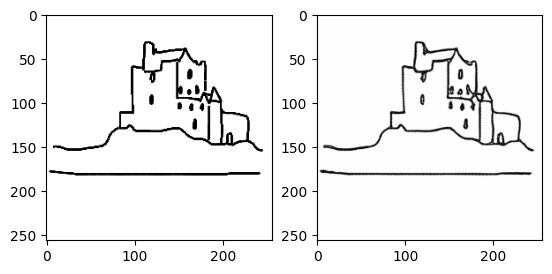

Would you like to keep the simplified edge maps? [Y]\[N]



 n


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


In [26]:
edge_maps = [Image.open("example-sketches/Sketch41.png")]
seed = 1000

inverse_diffusion = pipeline.Inference(prompt = ["A castle on a hill next to a lake"], 
                                           num_images_per_prompt = 1, 
                                           edge_maps = edge_maps, 
                                           negative_prompt = None, 
                                           num_inference_timesteps = 50, 
                                           classifier_guidance_strength = 8, 
                                           sketch_guidance_strength = 1.6,
                                           seed = seed,
                                           simplify_edge_maps = True,
                                           guidance_steps_perc = 0.5)

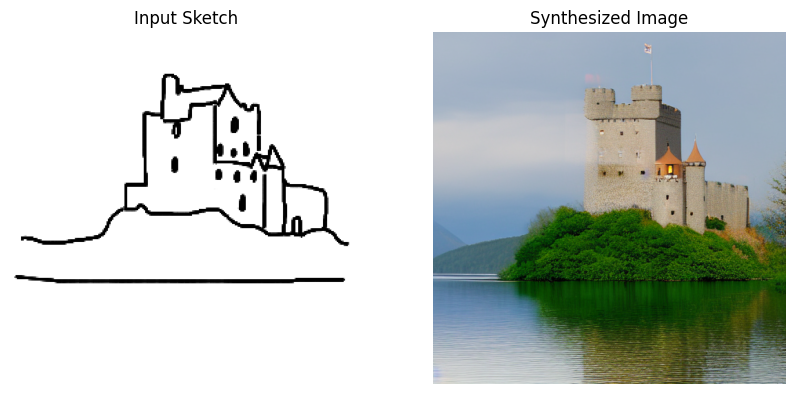

In [27]:
for edge_map, image in zip(edge_maps, inverse_diffusion["generated_image"]):
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    axs[0].imshow(edge_map)
    axs[1].imshow(image)
    axs[0].axis("off")
    axs[1].axis("off")
    axs[0].set_title("Input Sketch")
    axs[1].set_title("Synthesized Image")